<a href="https://colab.research.google.com/github/carlos-ochoa/ML_Notebooks/blob/main/KaggleDigit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer Kaggle competition

In this notebook I'm going to describe my development proccess in order to achieve a high accuray in this Kaggle competition:

https://www.kaggle.com/c/digit-recognizer/overview

This is my first competition :)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn import metrics
from collections import Counter
from sklearn.ensemble import VotingClassifier
import joblib


!pip install python-mnist
!pip install pickle

from pickle import load, dump

from mnist import MNIST

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


### Data preprocessing

So we have our data as a list of ints, but I want to use a vectorized form so let's create some numpy arrays with them so that they could be reshaped when needed.

It's a good idea to rescale our image's values, so I'm gonna divide every value in each array by 255



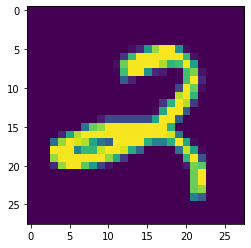

In [ ]:
# Load the training and testing data
(x_train, y_train), (x_test, y_test) = load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = np.reshape(x_train,(60000,784))
x_test = np.reshape(x_test,(10000,784))

x_train_nn = np.reshape(x_train,(60000,28,28,1))
x_test_nn = np.reshape(x_test,(10000,28,28,1))

index = random.randrange(0, 60000) 

plt.imshow(np.array(x_train[index]).reshape(28,28))

Fortunately, this dataset has been provided with preprocessed images, so that this step would be very little for everyone.

## Trying some models

This is the funny part! I'm gonna try some different models created with sklearn and tensorflow and maybe if I can do it make an ensembble model! We'll see haha

In [ ]:
# The first model is KNN, let's define a pipeline in order to reuse it later with other 

classifiers = {
  'knn' : KNeighborsClassifier(n_neighbors=25, weights = 'distance') ,
  'svc' : SVC(kernel = 'rbf'),
  'sgd' : SGDClassifier()
}

# Then let's create a dictionary of dictionaries that contain parameters for every classifier to be tested by randomized search

parameters = {}

parameters['knn'] = {
    'n_neighbors' : randint(1,500),
    'weights' : ['uniform','distance']
}

parameters['svc'] = {
    'C' : uniform(1, 10),
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'degree' : randint(1,10)
}

parameters['sgd'] = {
    'alpha': uniform(0.0001, 0.199)
}

# Now it's time to do a randomized search

clf_knn = RandomizedSearchCV(classifiers['knn'], parameters['knn'], n_iter = 100, cv = 5)
clf_svc = RandomizedSearchCV(classifiers['svc'], parameters['svc'], n_iter = 100, cv = 5)
clf_sgd = RandomizedSearchCV(classifiers['sgd'], parameters['sgd'], n_iter = 100, cv = 5)

print('training')
classifiers['knn'].fit(x_train, y_train)
y_pred = classifiers['knn'].predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
joblib.dump(classifiers['knn'], "knn2.sav")
'''
dump(classifiers['knn'], open("knn.sav", "wb"))

print('training')
classifiers['svc'].fit(x_train, y_train)
y_pred = classifiers['svc'].predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
dump(classifiers['svc'], open("svc.sav", "wb"))

print('training')
classifiers['sgd'].fit(x_train, y_train)
y_pred = classifiers['sgd'].predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
dump(classifiers['sgd'], open("sgd.sav", "wb"))

#search = clf_svc.fit(x_train, y_train)
#print(search.best_params_)
#print(search.cv_results_)
'''

training
0.9612


'\ndump(classifiers[\'knn\'], open("knn.sav", "wb"))\n\nprint(\'training\')\nclassifiers[\'svc\'].fit(x_train, y_train)\ny_pred = classifiers[\'svc\'].predict(x_test)\nprint(metrics.accuracy_score(y_test, y_pred))\ndump(classifiers[\'svc\'], open("svc.sav", "wb"))\n\nprint(\'training\')\nclassifiers[\'sgd\'].fit(x_train, y_train)\ny_pred = classifiers[\'sgd\'].predict(x_test)\nprint(metrics.accuracy_score(y_test, y_pred))\ndump(classifiers[\'sgd\'], open("sgd.sav", "wb"))\n\n#search = clf_svc.fit(x_train, y_train)\n#print(search.best_params_)\n#print(search.cv_results_)\n'

Next I'm going to try a CNN with a custom callback

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs["accuracy"]
    if val_acc >= 0.995:
       self.model.stop_training = True


In [ ]:
callbacks = MyCallback()

model = keras.Sequential(
    [
     keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (28,28,1)),
     keras.layers.MaxPool2D((2,2)),
     keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
     keras.layers.MaxPool2D((2,2)),
     keras.layers.Flatten(),
     keras.layers.Dense(units = 10, activation = 'softmax')
    ]
)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_nn, y_train, epochs = 200, verbose = 1, callbacks = [callbacks])

test_loss, test_acc = model.evaluate(x_test_nn,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/200
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2852 - accuracy: 0.9156
Epoch 2/200
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1066 - accuracy: 0.9684
Epoch 3/200
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0838 - accuracy: 0.9747
Epoch 4/200
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0708 - accuracy: 0.9784
Epoch 5/200
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0622 - accuracy: 0.9811
Epoch 6/200
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0559 - accuracy: 0.9826
Epoch 7/200
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0509 - accuracy: 0.9842
Epoch 8/200
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0470 - accuracy: 0.9855
Epoch 9/200
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0438 - accuracy: 0.9864
Epoch 10/200
1875/1875 [==============================]

In [ ]:
model.save('drive/My Drive/CNN')

INFO:tensorflow:Assets written to: drive/My Drive/CNN/assets


The next cell is only in case of needing the models to be loaded

In [ ]:
# load models 
classifiers['knn'] = joblib.load('knn2.sav')
classifiers['svc'] = load(open('svc.sav', 'rb'))
classifiers['sgd'] = load(open('sgd.sav', 'rb'))

nn = keras.models.load_model('drive/My Drive/CNN')

## Ensemble learning method

I want to try one more classifying method using ensemble learning by a max-voting classifier, first only trying with KNN, SVC and SGD. 

In [ ]:
voting_clf = VotingClassifier(
  estimators=[('knn', classifiers['knn']), ('svc', classifiers['svc']), ('sgd', classifiers['sgd'])],
  voting='hard'
)
voting_clf.fit(x_train, y_train)
y_pred = voting_clf.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred))

0.9692


As we can see, the accuracy of this is only 0.9692, not enough, even worse than SVC accuracy.

In [ ]:
dump(voting_clf, open("vote.sav", "wb"))

The next function is defined by myself. Only to add the CNN to the equation.

In [ ]:
# Ensemble learning

# predictions is a list containing every prediction of each classifier

def ensemble_predictions(predictions, len_pred):
  classes, final_predictions = [], []
  for prediction in range(len_pred):
    for p in predictions:
      #print(p[prediction])
      classes.append(p[prediction])
    most_common, count = Counter(classes).most_common(1)[0]
    final_predictions.append(most_common)
    classes.clear()
  return np.array(final_predictions)

In [ ]:

print('starting')
y_pred_knn = classifiers['knn'].predict(x_test)
print('Pred Knn')
y_pred_svc = classifiers['svc'].predict(x_test)
print('Pred SVC')
y_pred_sgd = classifiers['sgd'].predict(x_test)
print('Pred SGD')

y_pred_nn = nn.predict(x_test_nn)
print('Pred nn')





starting
Pred Knn
Pred SVC
Pred SGD
Pred nn


TypeError: ignored

In [ ]:
pred_nn = []
for p in y_pred_nn:
  pred_nn.append(np.argmax(p))

y_pred_nn = np.array(pred_nn)

preds = [y_pred_knn,y_pred_svc,y_pred_sgd,y_pred_nn]

y_pred = ensemble_predictions(preds, y_pred_knn.shape[0])

print(metrics.accuracy_score(y_test, y_pred))

0.9754


Not too good, CNN accuracy is better. So I'll try to optimize the CNN instead.